In [1]:
# Brent

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL

import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import r2_score

#### Load and Cleanse csv into Dataframe

In [3]:
df = pd.read_csv('./brent_price.csv')
# date is not date transform it into datetime
df['date'] = pd.to_datetime(df['DATE'])
df.dtypes
len_dataframe = len(df)
print(len_dataframe)

4587


In [4]:
df.describe()

,DCOILBRENTEU
count,4587.000000
mean,75.458886
std,25.245634
min,9.120000
25%,56.095000
50%,70.550000
75%,98.640000
max,143.950000


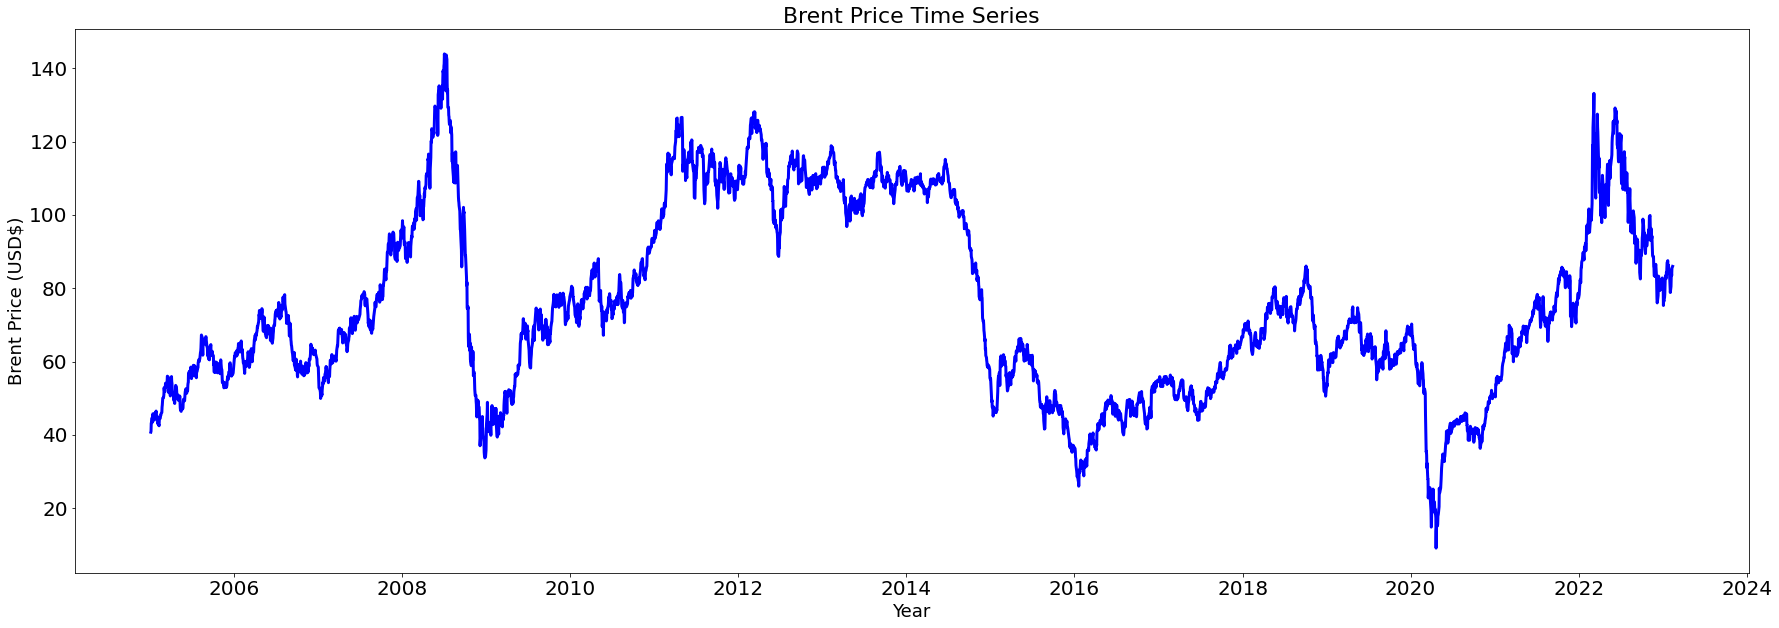

In [5]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))


ax.plot(df['date'],df['DCOILBRENTEU'],color='blue',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()

#### Time Series Decomposition to analyze Seasonality and Trend

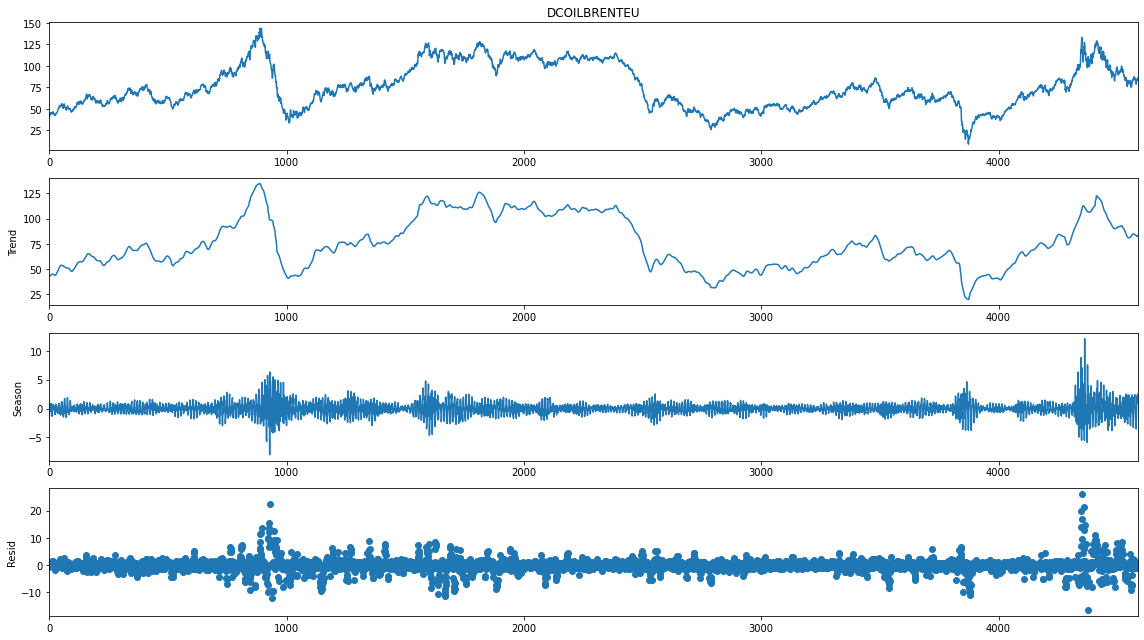

In [6]:
plt.rcParams["figure.figsize"] = [16,9]
stl = STL(df['DCOILBRENTEU'], period=12, robust=True)
result = stl.fit()
result.plot() 
plt.show()

In [74]:
# Time series is clearly without seasonality and trend
# We transform the prediction into a supervised learning approach
# <steps> - <prediction>
# How many steps can perform a horizon prediction?
ahead = 90     # we will perform at 90 days
lag = 50      # we use 10 steps as an example
length = len(df)

print('Number of steps (shape)', df.shape)
# we create a numpy array with all the steps
prices = df[["DCOILBRENTEU"]].to_numpy()

Number of steps (shape) (4587, 6)


In [75]:
s = prices
lvect = []

trainsize = len(s)
lvect = []
lvect2 = []
for i in range(lag, trainsize-lag-ahead):
   lvect.append(s[i:i+lag])
   lvect2.append(s[i+ahead+lag])   
X = np.stack(lvect, axis=1)
y = np.stack(lvect2, axis=1)
y = np.swapaxes(y, 1,0)
X = np.swapaxes(X, 0, 1)
X = np.squeeze(X)
y = np.squeeze(y)

In [76]:
# Split Train and Test
len_series = len(X)
cut = int(len_series*0.8)
train_x = X[:cut,:]
test_x  = X[cut:len_series,:]

train_y = y[:cut]
test_y  = y[cut:len_series]

In [77]:
print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("=============================================================")

=========== SHAPE INPUT-OUTPUT MATRIXES =====================
shape x_training : (3517, 50)  y_training: :  (3517,)
shape x_test     :  (880, 50)  y_test      :  (880,)


In [78]:
XGB = xgb.XGBRegressor()
XGB.fit(train_x, train_y)
y_hat = XGB.predict(test_x)

print('R2 Value:',   r2_score(test_y, y_hat))
print('MAPE Value:', mean_absolute_percentage_error(test_y, y_hat))

R2 Value: 0.45324065931089585
MAPE Value: 0.2859848110500196


In [79]:
#Create a column for y_hat
pad = []
for i in range(lag-1):
   pad.append('0')    
pad_arr = np.array(pad)
prevision = np.concatenate((pad_arr, y_hat))
prevision = np.concatenate((prevision, pad_arr))
#np.concatenate((a, b), axis=0)
start_prediction = len_dataframe - len(prevision)
pad = []
for i in range(start_prediction):
   pad.append('0')    
pad_arr = np.array(pad)
prevision = np.concatenate((pad_arr, prevision))
df['prevision'] = prevision
df['prevision'] = df['prevision'].astype(float)

In [80]:
#Create a column for y_test
pad = []
for i in range(lag-1):
   pad.append('0')    
pad_arr = np.array(pad)
zz = np.concatenate((pad_arr, test_y))
zz = np.concatenate((zz, pad_arr))
#np.concatenate((a, b), axis=0)
start_prediction = len_dataframe - len(zz)
pad = []
for i in range(start_prediction):
   pad.append('0')    
pad_arr = np.array(pad)
zz = np.concatenate((pad_arr, zz))
df['real'] = zz
df['real'] = df['real'].astype(float)

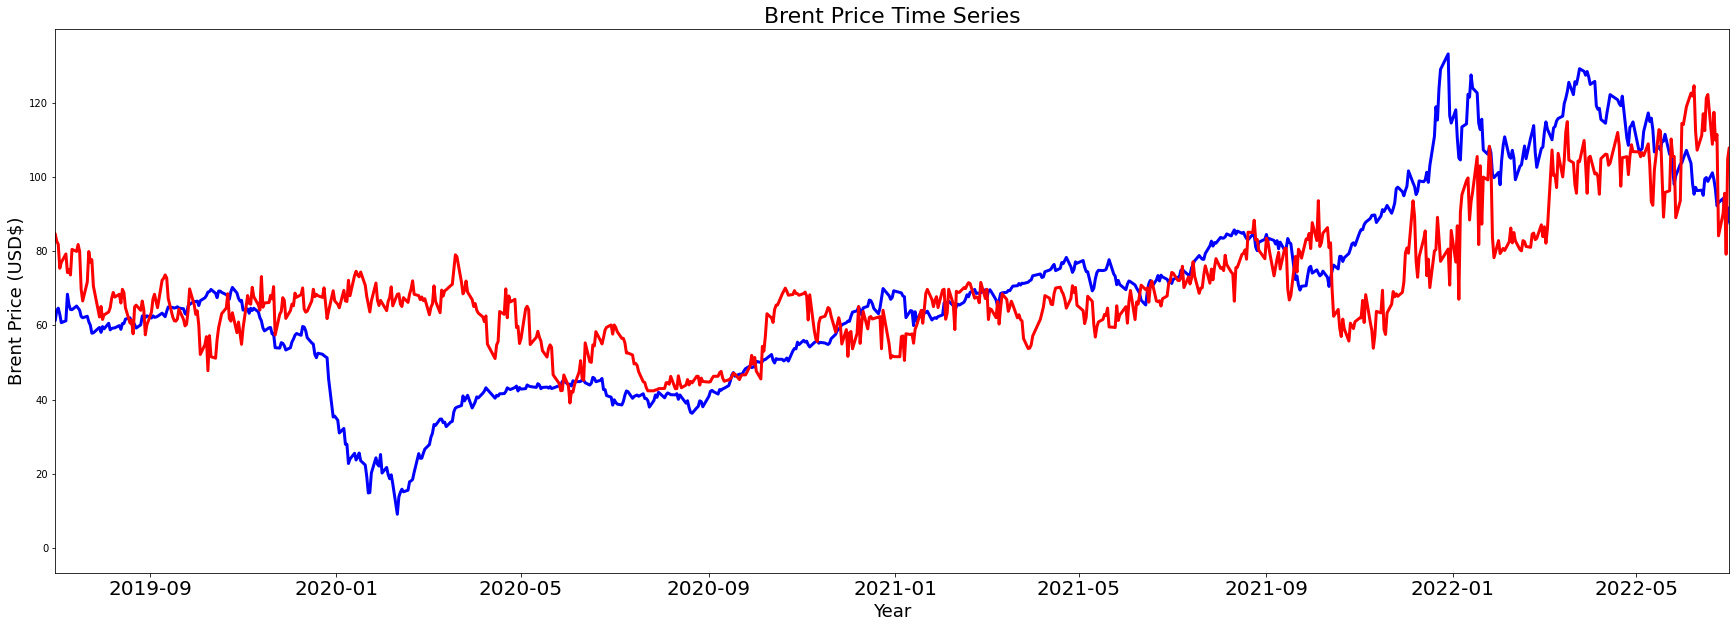

In [81]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df['date'],df['real'],color='blue',linewidth=3.0)
ax.plot(df['date'],df['prevision'],color='red',linewidth=3.0)
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title("Brent Price Time Series", size=22)
plt.ylabel("Brent Price (USD$)", size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.xlim('2019-07','2022-07')
#plt.yticks(fontsize=20)

#plt.savefig("figure_image.jpg")
plt.show()